# Importo librerias

In [5]:
pip install scikeras 

Note: you may need to restart the kernel to use updated packages.


In [20]:
import yfinance as yf
import pandas as pd
import numpy as np
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV


# Preparo los datos y los escalo

In [17]:
# 1. Descargar datos de yfinance
stock_1 = "BDORY"
stock_2 = "^BVSP"
fecha_inicial = "2020-05-31"  # Fecha histórica
fecha_final = "2025-05-31"    # Fecha actual

df_yf = yf.download(
    tickers=(stock_1, stock_2),
    start=fecha_inicial,
    end=fecha_final,
    interval="1d",
    group_by='ticker',
    auto_adjust=True
)
if df_yf.empty:
	df_yf = pd.read_csv('df_yfinance_raw.csv', header=[0,1], index_col=0, parse_dates=True)
 
df_yf.head()

[*********************100%***********************]  1 of 2 completed

2 Failed downloads:
['^BVSP', 'BDORY']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Ticker           PBR                                               ^BVSP  \
Price           Open      High       Low     Close      Volume      Open   
Date                                                                       
2020-01-02  5.424524  5.505689  5.404233  5.502307  13764800.0  115652.0   
2020-01-03  5.468489  5.509071  5.400851  5.407615  17661700.0  118564.0   
2020-01-06  5.356887  5.512453  5.356887  5.485398  16614500.0  117707.0   
2020-01-07  5.417761  5.448198  5.373797  5.431288  11277300.0  116872.0   
2020-01-08  5.400852  5.417761  5.282486  5.309541  22534200.0  116667.0   

Ticker                                                  BDORY            \
Price           High       Low     Close     Volume      Open      High   
Date                                                                      
2020-01-02  118573.0  115649.0  118573.0  5162700.0  4.456236  4.489817   
2020-01-03  118792.0  117341.0  117707.0  6834500.0  4.419298  4.462953   
2020-01-06  117707.0  116269.0  116878.0  6570000.0  4.352134  4.426013   
2020-01-07  117076.0  115965.0  116662.0  4854100.0  4.325269  4.355492   
2020-01-08  117335.0  115693.0  116247.0  5910500.0  4.321909  4.362206   

Ticker                                    
Price            Low     Close    Volume  
Date                                      
2020-01-02  4.432729  4.469668  187600.0  
2020-01-03  4.412582  4.432730  382600.0  
2020-01-06  4.352134  4.358850  594800.0  
2020-01-07  4.301762  4.338702  298800.0  
2020-01-08  4.308476  4.308476  165200.0

In [18]:
# 2. Crear DataFrame con regresores y características adicionales
df = pd.DataFrame({
    'y': df_yf[stock_1]['Close'],
    'bvsp_lag5': df_yf[stock_2]['Close'].shift(5)    
})
df = df.dropna().reset_index(drop=True)

# Eliminar filas con valores nulos
df.dropna(inplace=True)

print("\nDatos descargados y preprocesados:")
print(df.head())

# 3. Normalizar los datos
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)


Datos descargados y preprocesados:
          y  bvsp_lag5
0  4.187587   118573.0
1  4.090201   117707.0
2  4.110349   116878.0
3  4.080124   116662.0
4  3.969308   116247.0


# LSTM basic model

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.1000 - val_loss: 0.0063
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0260 - val_loss: 0.0330
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0168 - val_loss: 0.0260
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0198 - val_loss: 0.0137
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0156 - val_loss: 0.0031
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0106 - val_loss: 0.0038
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0108 - val_loss: 0.0133
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0113 - val_loss: 0.0032
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0106 - val_loss: 0.0033
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0083 - val_loss: 0.0114
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0091 - val_loss: 0.0027
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0085 - val_lo

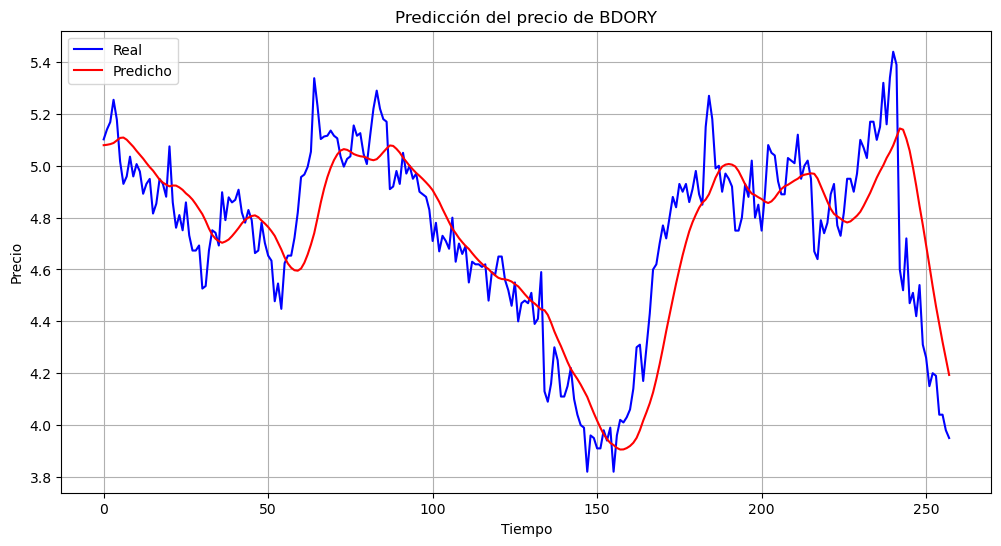

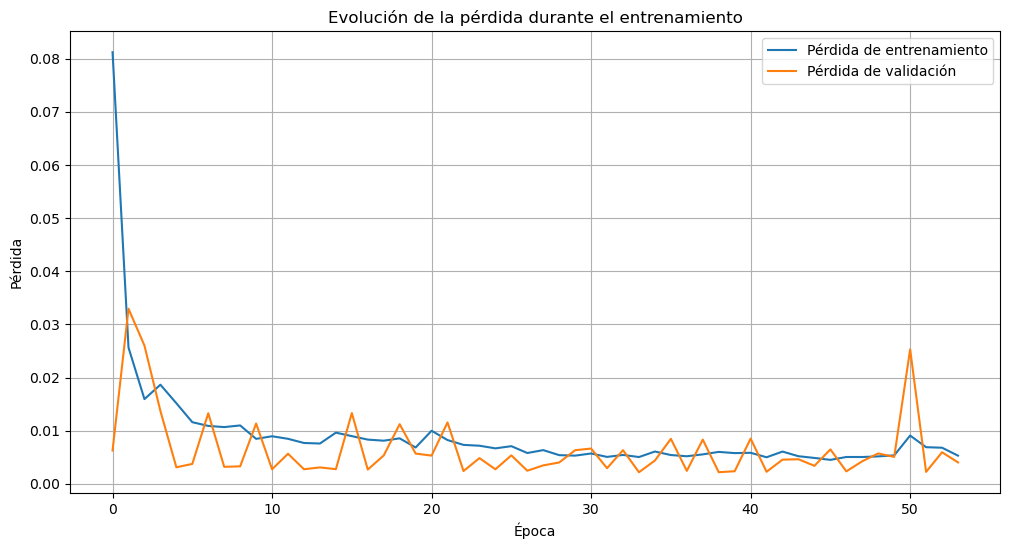

In [21]:
# 4. Crear secuencias para LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, :])
        y.append(data[i, 0])  # columna 0 es el precio de cierre de BDORY
    return np.array(X), np.array(y)

sequence_length = 25  # Aumentado para capturar más contexto
X, y = create_sequences(scaled_data, sequence_length)

# 5. Separar en entrenamiento y prueba
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# 6. Construir modelo LSTM mejorado
model = Sequential([
    Input(shape=(X.shape[1], X.shape[2])),  # Add this as the first layer
    LSTM(128, return_sequences=True),
    Dropout(0.5),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(1)
])

# Configurar early stopping
callbacks = [
    # detiene el entrenamiento si no hay mejora en la validación
    EarlyStopping(monitor='val_loss', patience=20,restore_best_weights=True),
    # ajusta el learning rate si no hay mejora en la validación
	#ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5) 
]

model.compile(optimizer='adam', loss='mse')
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=256,
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    verbose=1
)

# 7. Predicciones y desnormalización
predicted = model.predict(X_test)
y_test_actual = scaler.inverse_transform(np.concatenate((y_test.reshape(-1,1), np.zeros((len(y_test),scaled_data.shape[1]-1))), axis=1))[:,0]
predicted_actual = scaler.inverse_transform(np.concatenate((predicted, np.zeros((len(predicted),scaled_data.shape[1]-1))), axis=1))[:,0]

# 8. Evaluación del modelo
mse = mean_squared_error(y_test_actual, predicted_actual)
mae = mean_absolute_error(y_test_actual, predicted_actual)
r2 = r2_score(y_test_actual, predicted_actual)

print(f"\nMétricas de evaluación:")
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R2: {r2:.2f}")

# 9. Visualización
plt.figure(figsize=(12,6))
plt.plot(y_test_actual, label='Real', color='blue')
plt.plot(predicted_actual, label='Predicho', color='red')
plt.title('Predicción del precio de BDORY')
plt.xlabel('Tiempo')
plt.ylabel('Precio')
plt.legend()
plt.grid(True)
plt.show()

# 10. Visualizar la pérdida durante el entrenamiento
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Evolución de la pérdida durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)
plt.show()

# LSTM con más datos

Agregamos datos adicionales
- Precio de apertura
- Volumen
- Precio máximo
- Precio mínimo
- Volatilidad
- Precio de cierre
- Porcentaje de cambio
- Media de 5
- Media de 20

[*********************100%***********************]  2 of 2 completed

2 Failed downloads:
['^BVSP', 'BDORY']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Epoch 1/100


/opt/anaconda3/envs/ia_ceia_18co/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.1512 - val_loss: 0.0326
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0491 - val_loss: 0.0226
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0260 - val_loss: 0.0038
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0172 - val_loss: 0.0191
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0151 - val_loss: 0.0039
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0138 - val_loss: 0.0035
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0131 - val_loss: 0.0072
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0123 - val_loss: 0.0038
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0109 - val_loss: 0.0036
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0106 - val_loss: 0.0036
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0102 - val_loss: 0.0032
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0092 - val_loss: 0.0031
E

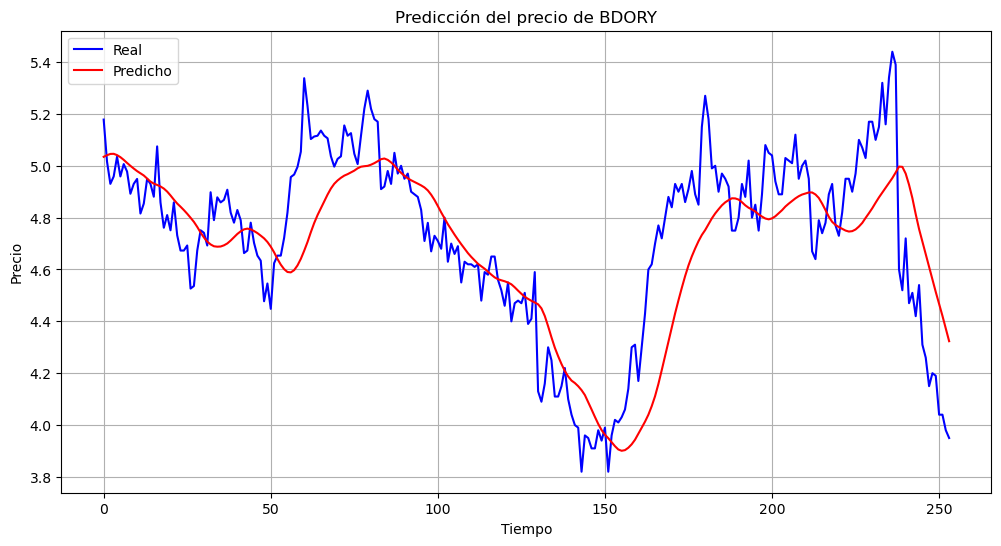

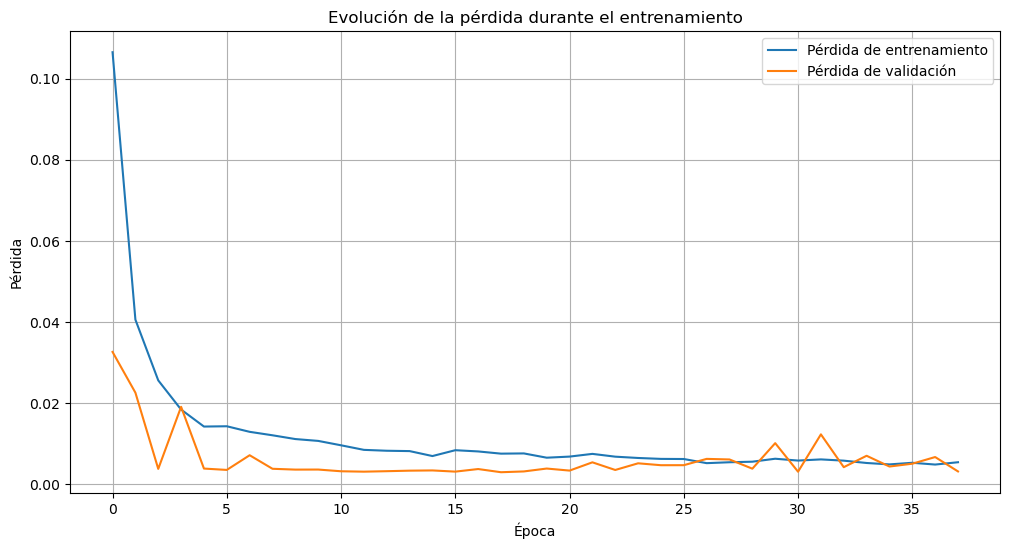

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1. Descargar datos de yfinance
stock_1 = "BDORY"
stock_2 = "^BVSP"
fecha_inicial = "2020-05-31"  # Fecha histórica
fecha_final = "2025-05-31"    # Fecha actual

df_yf = yf.download(
    tickers=(stock_1, stock_2),
    start=fecha_inicial,
    end=fecha_final,
    interval="1d",
    group_by='ticker',
    auto_adjust=True
)
if df_yf.empty:
	df_yf = pd.read_csv('df_yfinance_raw.csv', header=[0,1], index_col=0, parse_dates=True)

# 2. Crear DataFrame con regresores y características adicionales
df = pd.DataFrame({
    'y': df_yf[stock_1]['Close'],
    'bvsp_lag5': df_yf[stock_2]['Close'].shift(5),
    'volume_BDORY': df_yf[stock_1]['Volume'],
    'high_BDORY': df_yf[stock_1]['High'],
    'low_BDORY': df_yf[stock_1]['Low'],
    'open_BDORY': df_yf[stock_1]['Open']
})
df = df.dropna().reset_index(drop=True)

# Agregar características técnicas
df['returns'] = df['y'].pct_change()
df['volatility'] = df['returns'].rolling(window=5).std()
df['ma5'] = df['y'].rolling(window=5).mean()
df['ma20'] = df['y'].rolling(window=20).mean()

# Eliminar filas con valores nulos
df.dropna(inplace=True)

print("\nDatos descargados y preprocesados:")
print(df.head())

# 3. Normalizar los datos
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# 4. Crear secuencias para LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, :])
        y.append(data[i, 0])  # columna 0 es el precio de cierre de BDORY
    return np.array(X), np.array(y)

sequence_length = 25  # Aumentado para capturar más contexto
X, y = create_sequences(scaled_data, sequence_length)

# 5. Separar en entrenamiento y prueba
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# 6. Construir modelo LSTM mejorado
model = Sequential([
	Input(shape=(X.shape[1], X.shape[2])),  # Add this as the first layer
	LSTM(128, return_sequences=True),
    Dropout(0.5),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(1)
])

# Configurar early stopping
callbacks = [
    # detiene el entrenamiento si no hay mejora en la validación
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
    # ajusta el learning rate si no hay mejora en la validación
	#ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5) 
]		


model.compile(optimizer='adam', loss='mse')	

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=256,
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    verbose=1
)

# 7. Predicciones y desnormalización
predicted = model.predict(X_test)
y_test_actual = scaler.inverse_transform(np.concatenate((y_test.reshape(-1,1), np.zeros((len(y_test),scaled_data.shape[1]-1))), axis=1))[:,0]
predicted_actual = scaler.inverse_transform(np.concatenate((predicted, np.zeros((len(predicted),scaled_data.shape[1]-1))), axis=1))[:,0]

# 8. Evaluación del modelo
mse = mean_squared_error(y_test_actual, predicted_actual)
mae = mean_absolute_error(y_test_actual, predicted_actual)
r2 = r2_score(y_test_actual, predicted_actual)

print(f"\nMétricas de evaluación:")
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R2: {r2:.2f}")

# 9. Visualización
plt.figure(figsize=(12,6))
plt.plot(y_test_actual, label='Real', color='blue')
plt.plot(predicted_actual, label='Predicho', color='red')
plt.title('Predicción del precio de BDORY')
plt.xlabel('Tiempo')
plt.ylabel('Precio')
plt.legend()
plt.grid(True)
plt.show()

# 10. Visualizar la pérdida durante el entrenamiento
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Evolución de la pérdida durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)
plt.show()

# LSTM con gridsearch

In [ ]:
# 1. Descargar datos de yfinance
stock_1 = "BDORY"
stock_2 = "^BVSP"
fecha_inicial = "2020-05-31"  # Fecha histórica
fecha_final = "2025-05-31"    # Fecha actual

df_yf = yf.download(
    tickers=(stock_1, stock_2),
    start=fecha_inicial,
    end=fecha_final,
    interval="1d",
    group_by='ticker',
    auto_adjust=True
)
if df_yf.empty:
	df_yf = pd.read_csv('df_yfinance_raw.csv', header=[0,1], index_col=0, parse_dates=True)

# 2. Crear DataFrame con regresores y características adicionales
df = pd.DataFrame({
    'y': df_yf[stock_1]['Close'],
    'bvsp_lag5': df_yf[stock_2]['Close'].shift(5),
    'volume_BDORY': df_yf[stock_1]['Volume'],
    'high_BDORY': df_yf[stock_1]['High'],
    'low_BDORY': df_yf[stock_1]['Low'],
    'open_BDORY': df_yf[stock_1]['Open']
})
df = df.dropna().reset_index(drop=True)

# Agregar características técnicas
df['returns'] = df['y'].pct_change()
df['volatility'] = df['returns'].rolling(window=5).std()
df['ma5'] = df['y'].rolling(window=5).mean()
df['ma20'] = df['y'].rolling(window=20).mean()

# Eliminar filas con valores nulos
df.dropna(inplace=True)

print("Datos descargados y procesados:")
print(df.head())

# 3. Normalizar los datos
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# 4. Crear secuencias para LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, :])
        y.append(data[i, 0])  # columna 0 es el precio de cierre de BDORY
    return np.array(X), np.array(y)

sequence_length = 25  # Aumentado para capturar más contexto
X, y = create_sequences(scaled_data, sequence_length)

# 5. Separar en entrenamiento y prueba
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

[*********************100%***********************]  2 of 2 completed

2 Failed downloads:
['BDORY', '^BVSP']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


## Defino el grid search

In [12]:
def build_model(units=128, dropout=0.2, lr=0.001):
    model = Sequential()
    model.add(LSTM(units, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(1))    
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse')
    return model   


In [13]:
# KerasRegressor is used to wrap the Keras model for use in scikit-learn pipelines
regressor = KerasRegressor(build_fn=build_model, verbose=0, dropout=0.2, lr=0.0005, units=64)


In [14]:
param_grid = {
    'units': [32, 64, 128, 256],
    'dropout': [0.2, 0.5],
    'lr': [0.01, 0.0005],
    'epochs': [20, 200],
    'batch_size': [4, 64]
}

In [ ]:
grid = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
grid_result = grid.fit(X_train, y_train)

In [ ]:
print("Mejor score: %f usando %s" % (grid_result.best_score_, grid_result.best_params_))


Mejor score: -0.000476 usando {'batch_size': 4, 'dropout': 0.2, 'epochs': 200, 'lr': 0.0005, 'units': 256}


## Corro con los mejores parametros

In [ ]:
# Seteo los mejores hiperparámetros encontrados
#batch_size=16
#dropout=0.2
#epochs=50
#lr=0.0005
#units=128

In [ ]:
# Seteo los mejores hiperparámetros encontrados
#batch_size=4
#dropout=0.2
#epochs=20
#lr=0.001
#units=256

In [25]:
# Seteo los mejores hiperparámetros encontrados
batch_size=4
dropout=0.2
epochs=200
lr=0.0005
units=256

[*********************100%***********************]  2 of 2 completed

2 Failed downloads:
['BDORY', '^BVSP']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


           y  bvsp_lag5  volume_BDORY  high_BDORY  low_BDORY  open_BDORY  \
19  3.878639   115528.0      189800.0    3.976024   3.865206    3.976024   
20  3.905504   113761.0      124600.0    3.912220   3.851774    3.861848   
21  3.798043   114629.0      570800.0    3.858489   3.798043    3.841698   
22  4.006248   115557.0      577400.0    4.019681   3.969308    3.976025   
23  3.976023   116028.0      778400.0    4.033112   3.922293    3.989456   

     returns  volatility       ma5      ma20  
19 -0.030227    0.030901  3.873265  3.990967  
20  0.006926    0.028347  3.895429  3.976863  
21 -0.027515    0.030670  3.881996  3.962255  
22  0.054819    0.039529  3.917593  3.957050  
23 -0.007544    0.034562  3.912891  3.951845  
Epoch 1/200


/opt/anaconda3/envs/ia_ceia_18co/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


254/254 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0101 - val_loss: 0.0024
Epoch 2/200
254/254 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0039 - val_loss: 0.0035
Epoch 3/200
254/254 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0024 - val_loss: 0.0032
Epoch 4/200
254/254 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0028 - val_loss: 0.0044
Epoch 5/200
254/254 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0021 - val_loss: 0.0017
Epoch 6/200
254/254 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 7/200
254/254 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 8/200
254/254 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 9/200
254/254 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 10/200
254/254 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 11/200
254/254 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 12/200
254/254 ━━━━━━━━━━━━━━━━━━━━ 

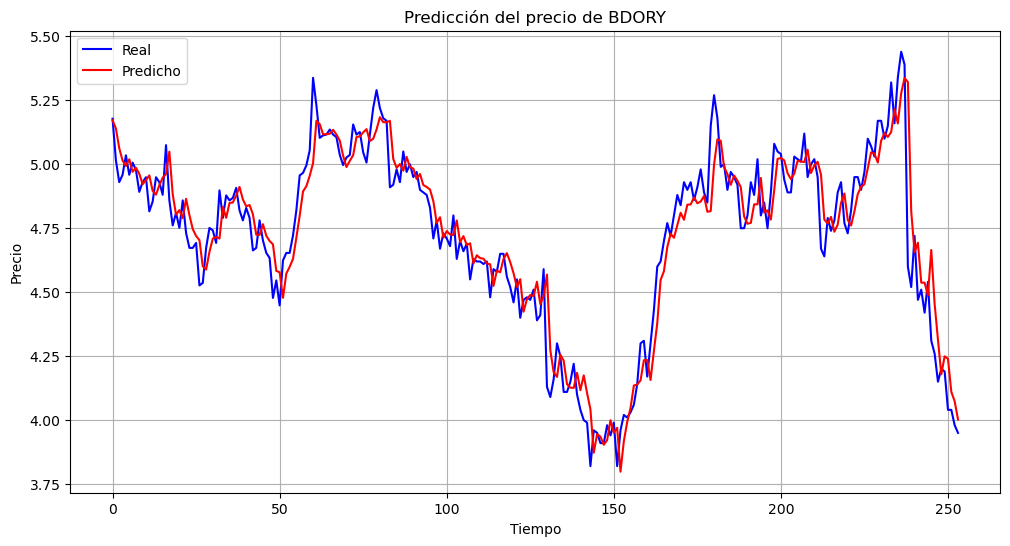

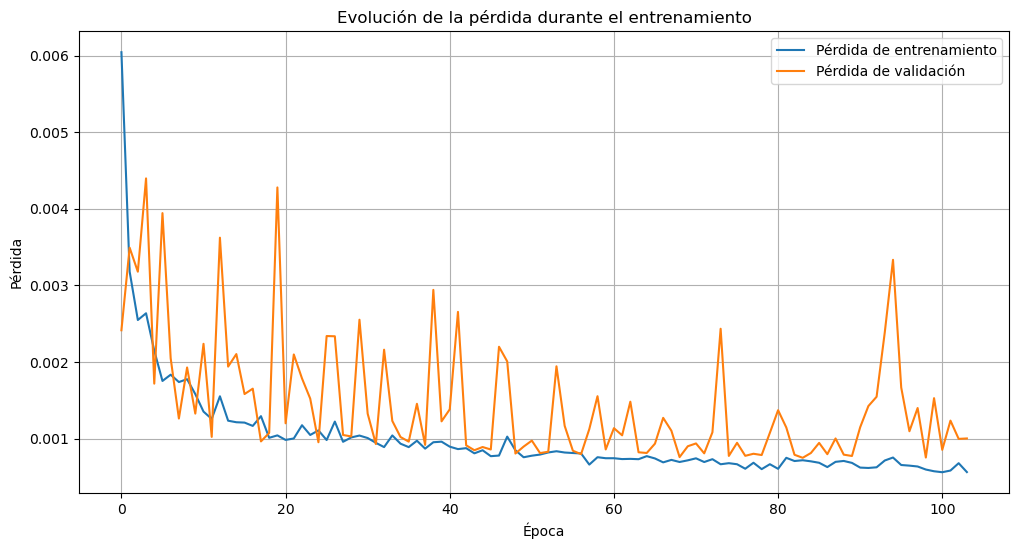

In [26]:
# 1. Descargar datos de yfinance
stock_1 = "BDORY"
stock_2 = "^BVSP"
fecha_inicial = "2020-05-31"  # Fecha histórica
fecha_final = "2025-05-31"    # Fecha actual

df_yf = yf.download(
    tickers=(stock_1, stock_2),
    start=fecha_inicial,
    end=fecha_final,
    interval="1d",
    group_by='ticker',
    auto_adjust=True
)
if df_yf.empty:
	df_yf = pd.read_csv('df_yfinance_raw.csv', header=[0,1], index_col=0, parse_dates=True)

# 2. Crear DataFrame con regresores y características adicionales
df = pd.DataFrame({
    'y': df_yf[stock_1]['Close'],
    'bvsp_lag5': df_yf[stock_2]['Close'].shift(5),
    'volume_BDORY': df_yf[stock_1]['Volume'],
    'high_BDORY': df_yf[stock_1]['High'],
    'low_BDORY': df_yf[stock_1]['Low'],
    'open_BDORY': df_yf[stock_1]['Open']
})
df = df.dropna().reset_index(drop=True)

# Agregar características técnicas
df['returns'] = df['y'].pct_change()
df['volatility'] = df['returns'].rolling(window=5).std()
df['ma5'] = df['y'].rolling(window=5).mean()
df['ma20'] = df['y'].rolling(window=20).mean()

# Eliminar filas con valores nulos
df.dropna(inplace=True)

print(df.head())

# 3. Normalizar los datos
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# 4. Crear secuencias para LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, :])
        y.append(data[i, 0])  # columna 0 es el precio de cierre de BDORY
    return np.array(X), np.array(y)

sequence_length = 25  # Aumentado para capturar más contexto
X, y = create_sequences(scaled_data, sequence_length)

# 5. Separar en entrenamiento y prueba
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# 6. Construir modelo LSTM mejorado
model = Sequential([
    LSTM(units, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    Dropout(dropout),
    LSTM(128, return_sequences=False),
    Dropout(dropout),
    Dense(56, activation='relu'),
    Dense(1)
])

# Configurar early stopping
callbacks = [
    # detiene el entrenamiento si no hay mejora en la validación
    EarlyStopping(monitor='val_loss', patience=20,restore_best_weights=True),
    # ajusta el learning rate si no hay mejora en la validación
	#ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5) 
]

model.compile(optimizer=Adam(learning_rate=lr), loss='mse')

history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    verbose=1
)

# 7. Predicciones y desnormalización
predicted = model.predict(X_test)
y_test_actual = scaler.inverse_transform(np.concatenate((y_test.reshape(-1,1), np.zeros((len(y_test),scaled_data.shape[1]-1))), axis=1))[:,0]
predicted_actual = scaler.inverse_transform(np.concatenate((predicted, np.zeros((len(predicted),scaled_data.shape[1]-1))), axis=1))[:,0]

# 8. Evaluación del modelo
mse = mean_squared_error(y_test_actual, predicted_actual)
mae = mean_absolute_error(y_test_actual, predicted_actual)
r2 = r2_score(y_test_actual, predicted_actual)

print(f"\n ### Métricas de evaluación: ###")
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R2: {r2:.2f}")

# 9. Visualización
plt.figure(figsize=(12,6))
plt.plot(y_test_actual, label='Real', color='blue')
plt.plot(predicted_actual, label='Predicho', color='red')
plt.title('Predicción del precio de BDORY')
plt.xlabel('Tiempo')
plt.ylabel('Precio')
plt.legend()
plt.grid(True)
plt.show()

# 10. Visualizar la pérdida durante el entrenamiento
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Evolución de la pérdida durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)
plt.show()

### Evolución de la pérdida (loss) en entrenamiento y validación
Muestra si tu modelo está aprendiendo y si hay overfitting.

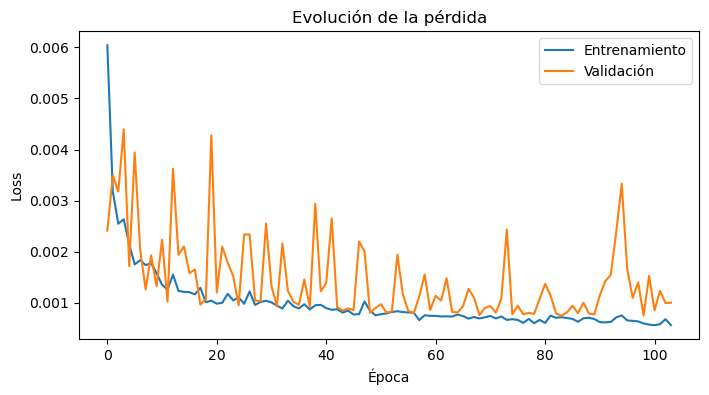

In [27]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Entrenamiento')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validación')
plt.title('Evolución de la pérdida')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.show()


### Valores reales vs. predichos en test (scatter plot)

Permite ver si hay sesgo sistemático y cómo se distribuyen los errores.

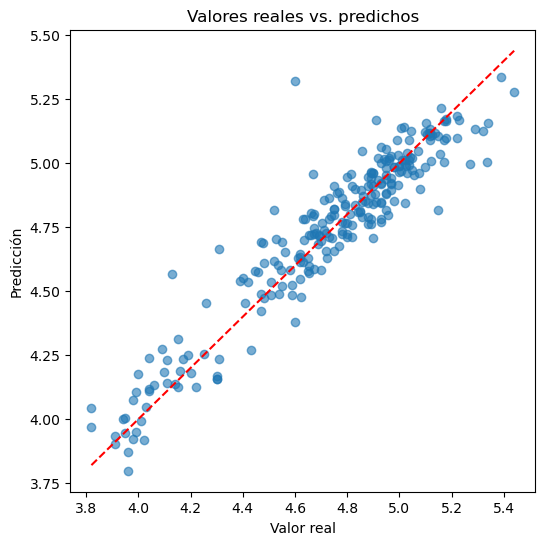

In [28]:
plt.figure(figsize=(6,6))
plt.scatter(y_test_actual, predicted_actual, alpha=0.6)
plt.plot([min(y_test_actual), max(y_test_actual)], [min(y_test_actual), max(y_test_actual)], 'r--')
plt.xlabel('Valor real')
plt.ylabel('Predicción')
plt.title('Valores reales vs. predichos')
plt.show()


### Errores de predicción a lo largo del tiempo
Útil para detectar períodos donde el modelo falla más.

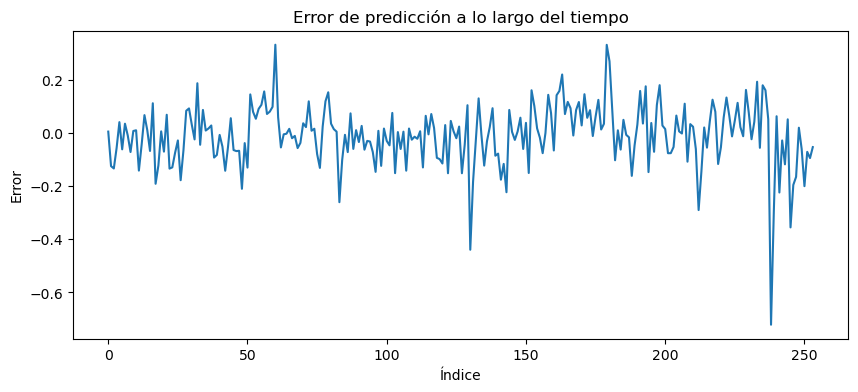

In [29]:
errores = y_test_actual - predicted_actual
plt.figure(figsize=(10,4))
plt.plot(errores)
plt.title('Error de predicción a lo largo del tiempo')
plt.xlabel('Índice')
plt.ylabel('Error')
plt.show()

### Gráfico conjunto: serie temporal de valores reales y predichos

Si tienes la fecha, grafica ambos sobre el eje temporal para ver cómo sigue el modelo la tendencia real.

In [30]:
plt.figure(figsize=(12,5))
plt.plot(df_yfinance_test.index, y_test_actual, label='Real')
plt.plot(df_yfinance_test.index, predicted_actual, label='Predicción')
plt.title('Serie temporal: Real vs Predicho')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()
plt.show()

NameError: name 'df_yfinance_test' is not defined

<Figure size 1200x500 with 0 Axes>